# GuillaumeNet

This is a implementation of http://arxiv.org/pdf/1511.00561v2.pdf (Except for the Upsampling layer where paper uses indices based upsampling which is not implemented in keras yet( *I am working on it*), but that shouldnt make a lot of difference)


### TODO

In [1]:
#sudo ldconfig /usr/local/cuda-7.5/lib64

In [2]:
pathSave = 'data/'

%matplotlib inline
import os
#pathToDataset = '/home/optimus/AI/work/modal/CamVid/'
os.environ['KERAS_BACKEND'] = 'theano'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32,optimizer=fast_compile'
os.environ['THEANO_FLAGS']='device=gpu,floatX=float32'
import cv2
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(1337) # for reproducibility
from keras.layers.noise import GaussianNoise
import keras.models as models

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D , UpSampling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import *
from keras.layers.core import Dropout
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.regularizers import ActivityRegularizer
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import load_model




Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN not available)


In [3]:
Sky = [0,128,192]
Building = [64,64,64]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,128,128]
Pavement = [60,40,60]
Tree = [0,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [96,0,0]
Pedestrian = [255,0,0]
Bicyclist = [128,128,0]
Unlabelled = [0,0,0]

#label_colours = np.array([Sky, Building, Pole, Road, Pavement,
 #                         Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])
#label_names=['Sky','Building','Pole','Road','Pavement',
   #          'Tree' ,'SignSymbol' ,'Fence' ,'Car', 'Pedestrian', 'BiCyclist','Unlabelled']

#classes_importance = [9,8,10,6,2,7,5,4,1,3,0,11]
# pedestrian, car, bicyclist, signsymbol, pole, fence, tree, pavement,building, road, sky, unlabelled
#filtre_attribution_label = [0.2,0.2,0.2,0.2,0.2,0.5,0.6,0.75,0.97,0.97,0.98,0.7]
# class weigths
#class_weighting = [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]

#  unchangeable variables
nb_classes=8
data_shape = 240*480

width=480
height=240

window_size=(64,64) #format width*height
pad=20

classes_names =['flat','human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void']
classes_colors = [Road, Pedestrian, Car, Building, SignSymbol, Tree, Sky, Unlabelled]
classes_importance = [1,2,4,5,0,3,6,7] # avirer ?
filtre_attribution_label = [0.97,0.4,0.7,0.95,0.5,0.8,0.99,0.99] # avirer ?

In [4]:
# cityscape order
void = [0,0,0]
ground = [128,128,128]
construction = [192,128,128]
object2 = [128,128,192]
nature =[0,255,0]
sky = [0,0,255]
human = [255,0,0]
vehicle = [0,0,100]

classes_names = np.array(['void','ground','construction','object','nature','sky','human','vehicle'])
classes_colors = np.array([void,ground,construction,object2,nature,sky,human,vehicle])

## Data Fetching 
I equalized histograms of rbg layers separately, so that change in lighting doesnt effect the results.

In [9]:
from shared_fonctions import *

train_data, train_label = [],[]

for i in range(nb_classes):
    print "Loading class ",classes_names[i]
    z = load_class(i,10000)
    train_label.extend(create_label_matrix(i,len(z),nb_classes))
    train_data.extend(z)
    

print "Nb Examples :",len(train_data)

#train_data,train_label = load_data('camvid', 'train',range(1,9))
#test_data,test_label = load_camvid_test_data([1])
# on ne peut pas utiliser simultanément camvid et cityscape !

Loading class  void
Loading class  ground
Loading class  construction
Loading class  object
Loading class  nature
Loading class  sky
Loading class  human
Loading class  vehicle
Nb Examples : 71014


## Display Class repartition

In [10]:
train_data = np.array(train_data)
train_label = np.array(train_label)

print(train_data.shape)
print(train_label.shape)

hc_train = histoclass(train_label)
print hc_train
#hc_test = histoclass(test_label)
class_weighting = 1000./(hc_train+0.1)
print 100*hc_train/np.sum(hc_train)
#print hc_test

ratios = 100.00*hc_train/np.sum(hc_train)

print('\n'.join('{}: {}'.format(*k) for k in enumerate(ratios)))

#print '{} {} {} {} {} {} {} {} {} {} {} {}'.format(ratios)

class_weighting

(71014, 64, 64, 3)
(71014, 8)
[ 9266 10000 10000  1748 10000 10000 10000 10000]
[13 14 14  2 14 14 14 14]
0: 13.0481313544
1: 14.081730363
2: 14.081730363
3: 2.46148646746
4: 14.081730363
5: 14.081730363
6: 14.081730363
7: 14.081730363


array([ 0.10792027,  0.099999  ,  0.099999  ,  0.57204965,  0.099999  ,
        0.099999  ,  0.099999  ,  0.099999  ])

## Show random images

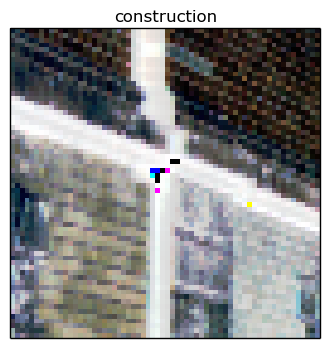

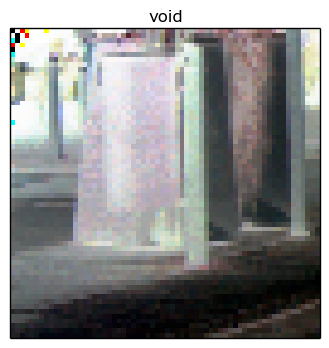

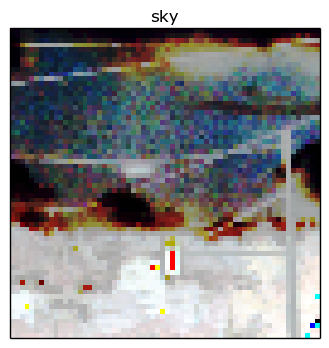

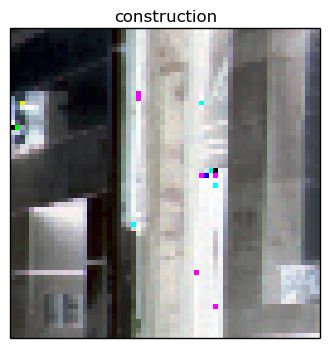

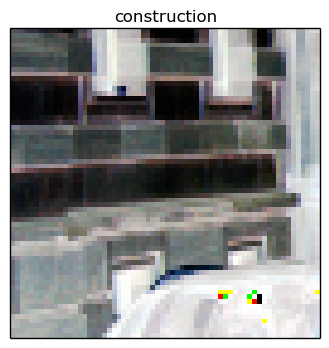

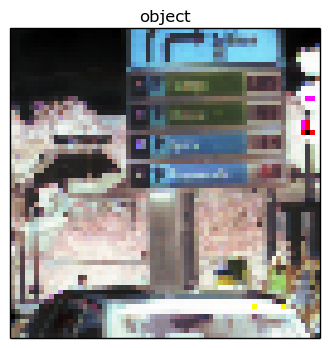

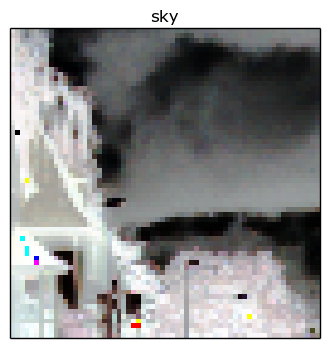

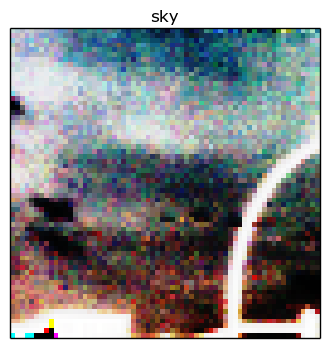

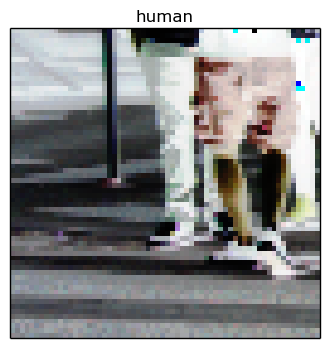

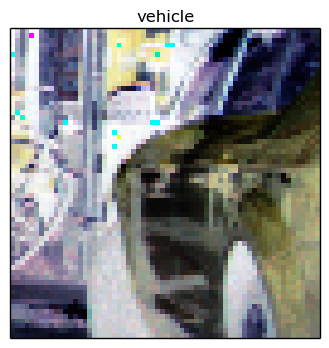

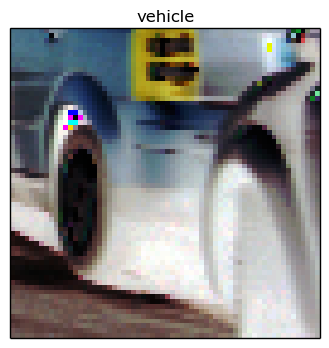

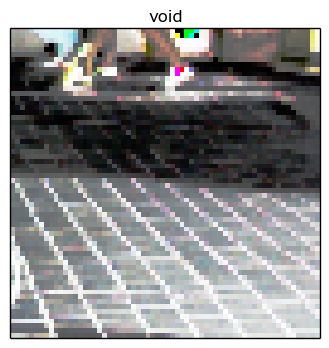

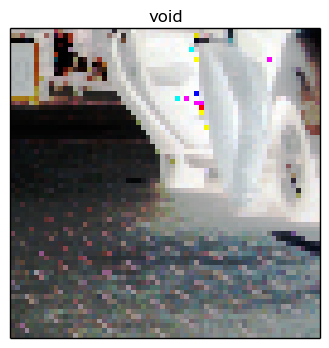

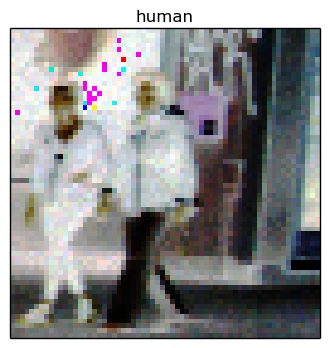

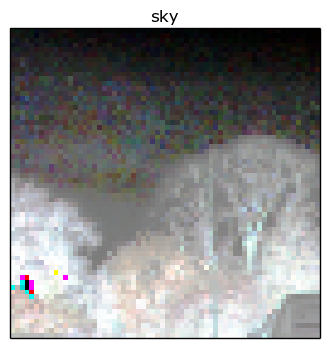

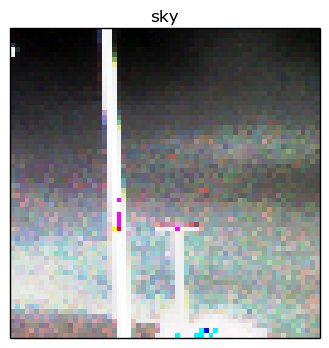

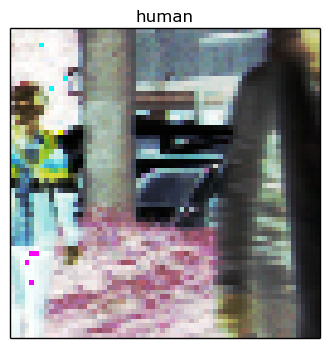

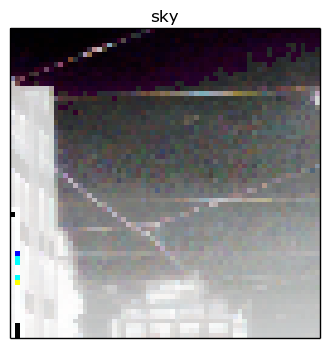

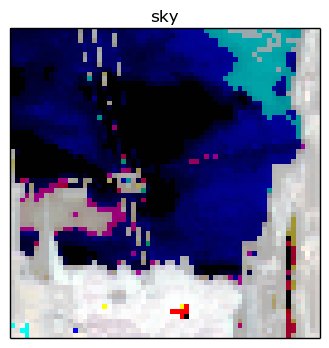

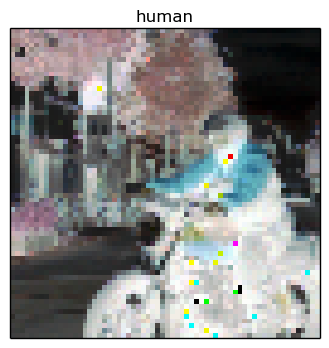

In [11]:
show_sample(train_data, train_label, 20, classes_names)


### Creating and Compiling neuralnet

In [ ]:
def VGG_16_moi(weights_path=None):
    """ Ne pas oublier de configurer ~/.keras/keras.json pour utiliser le backend th """
    model = Sequential()
    model.add(UpSampling2D(size = (2,2),input_shape=(64,64,3)))
    model.add(UpSampling2D(size = (2,2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    
    return model

In [ ]:
def to_delete():
    weights_path = 'data/vgg16_weights.h5'
    import h5py

    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers) - 3:
            # we don't look at the last two layers in the savefile (fully-connected and activation)
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        layer = model.layers[k+2]

        if layer.__class__.__name__ in ['Convolution1D', 'Convolution2D', 'Convolution3D', 'AtrousConvolution2D']:
            weights[0] = np.transpose(weights[0], (2, 3, 1, 0))

        layer.set_weights(weights)
    f.close()
    model.summary()

    model.save_weights('data/vgg16_weights2.h5')
    return None


In [ ]:
def create_lenet():
    model1 = models.Sequential()
    model1.add(Convolution2D(20, 5, 5, border_mode="same",input_shape=(window_size[1], window_size[0],3)))
    model1.add(Activation("relu"))
    print(model1.output_shape)
    model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    print(model1.output_shape)
    model1.add(Convolution2D(50, 5, 5, border_mode="same"))
    model1.add(Activation("relu"))
    print(model1.output_shape)
    model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    print(model1.output_shape)
    model1.add(Flatten())
    model1.add(Dense(700))
    model1.add(Activation("relu"))

    # softmax classifier
    model1.add(Dense(nb_classes))
    model1.add(Activation("softmax"))
    optimizer = SGD(lr=0.0001, momentum=0.8, decay=0.01, nesterov=False)
    # good opt : optimizer = SGD(lr=0.0001, momentum=0.8, decay=0.01, nesterov=False)
    # batchsize : 64
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=['categorical_accuracy'])
    return model1

In [ ]:
def create_lenet_costaud():
    model1 = models.Sequential()
    model1.add(Convolution2D(50, 5, 5, border_mode="same",input_shape=(window_size[1], window_size[0],3)))
    model1.add(Activation("relu"))
    print(model1.output_shape)
    model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    print(model1.output_shape)
    model1.add(Convolution2D(100, 5, 5, border_mode="same"))
    model1.add(Activation("relu"))
    print(model1.output_shape)
    model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    print(model1.output_shape)
    model1.add(Flatten())
    model1.add(Dense(1000))
    model1.add(Activation("relu"))

    # softmax classifier
    model1.add(Dense(nb_classes))
    model1.add(Activation("softmax"))
    optimizer = SGD(lr=0.01, momentum=0.8, decay=0.01, nesterov=False)
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=['categorical_accuracy'])
    return model1

In [13]:
def small_vgg(weights_path=None):
    model = Sequential()
    model.add(Convolution2D(50, 3, 3, border_mode="same",input_shape=(window_size[1], window_size[0],3)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(50, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(100, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(100, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(200, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(200, 3, 3, activation='relu'))
   
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)
    opt1 = SGD(lr=0.0001, decay=1e-5, momentum=0.9, nesterov=True)
    opt2 = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
    opt3 = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    
    return model

In [14]:
#model = create_lenet()
#model = create_lenet_costaud()
model = small_vgg()

(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)


In [17]:
nb_epoch = 100
batch_size = 128

In [18]:
history = model.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,class_weight=class_weighting)

Epoch 1/100
71014/71014 [==============================] - 495s - loss: 2.0515 - categorical_accuracy: 0.1504   
Epoch 2/100
71014/71014 [==============================] - 495s - loss: 1.8471 - categorical_accuracy: 0.2710   
Epoch 3/100
71014/71014 [==============================] - 495s - loss: 1.6649 - categorical_accuracy: 0.3622   
Epoch 4/100
71014/71014 [==============================] - 495s - loss: 1.4922 - categorical_accuracy: 0.4467   
Epoch 5/100
71014/71014 [==============================] - 495s - loss: 1.4071 - categorical_accuracy: 0.4820   
Epoch 6/100
71014/71014 [==============================] - 495s - loss: 1.3267 - categorical_accuracy: 0.5146   
Epoch 7/100
71014/71014 [==============================] - 495s - loss: 1.2528 - categorical_accuracy: 0.5468   
Epoch 8/100
71014/71014 [==============================] - 495s - loss: 1.1860 - categorical_accuracy: 0.5746   
Epoch 9/100
71014/71014 [==============================] - 495s - loss: 1.1349 - categorical_acc

### Test

In [19]:
#model.save('saved_models/small_vgg_lr0.0001decay1e-5mom0.9nesttrue_70000examples100epochs')
#model.save('small_vgg_1')
#model.save('saved_models/lenet_8000')

In [20]:
classes_train_accuracy = []
classes_test_accuracy = []

#print(train_label.shape)

test_label = []
test_data = []


for i in range(nb_classes):
    print "Loading class ",classes_names[i]
    z = np.load('data/cityscape/test/'+str(i)+'/zurich.npy')
    test_label.extend(create_label_matrix(i,len(z),nb_classes))
    test_data.extend(z)
    
test_data = np.array(test_data)
test_label = np.array(test_label)
    
for i in range(nb_classes):
    score = model.evaluate(train_data[train_label[:,i]==1],train_label[train_label[:,i]==1], verbose=0)
    print 'Train accuracy on class ',i,' (',classes_names[i],') :',score[1]
    classes_train_accuracy.append(score[1])
print 'Mean train accuracy :',np.mean(classes_train_accuracy)


for i in range(nb_classes):
    score = model.evaluate(test_data[test_label[:,i]==1],test_label[test_label[:,i]==1], verbose=0)
    print 'Test accuracy on class ',i,' (',classes_names[i],') :',score[1]
    classes_test_accuracy.append(score[1])
print 'Mean test accuracy :',np.mean(classes_test_accuracy)


Loading class  void
Loading class  ground
Loading class  construction
Loading class  object
Loading class  nature
Loading class  sky
Loading class  human
Loading class  vehicle
Train accuracy on class  0  ( void ) : 0.999892078567
Train accuracy on class  1  ( ground ) : 0.9996
Train accuracy on class  2  ( construction ) : 1.0
Train accuracy on class  3  ( object ) : 1.0
Train accuracy on class  4  ( nature ) : 1.0
Train accuracy on class  5  ( sky ) : 1.0
Train accuracy on class  6  ( human ) : 1.0
Train accuracy on class  7  ( vehicle ) : 1.0
Mean train accuracy : 0.999936509821
Test accuracy on class  0  ( void ) : 1.0
Test accuracy on class  1  ( ground ) : 0.802313354489
Test accuracy on class  2  ( construction ) : 0.804405286659
Test accuracy on class  3  ( object ) : 1.0
Test accuracy on class  4  ( nature ) : 0.794462193696
Test accuracy on class  5  ( sky ) : 0.975460122821
Test accuracy on class  6  ( human ) : 0.930269414385
Test accuracy on class  7  ( vehicle ) : 0.82673

In [ ]:
print (test_data.shape)

### Visualization
I trained autoencoder sepeartely with 100 epochs, loading weights here.

In [ ]:
#model1.load_weights('model_weights.hdf5')

In [21]:
def pred(img,pad): # prédiction sur une image
    result=np.zeros((240,480,nb_classes))
    out=np.zeros((240,480))
    for j in range(0,width-window_size[0],pad):
            for k in range(0,height-window_size[1],pad):
                window = img[k:k+window_size[1],j:j+window_size[0]]
                window = normalized(window)
                one_hot=model.predict_proba(np.array([window]),verbose=0)[0]
                a=np.zeros((window_size[1],window_size[0],nb_classes))
                a[:,:]=one_hot
                result[k:k+window_size[1],j:j+window_size[0]]+=a
    for i in range(240):
        for j in range(480):
            out[i,j]=np.argmax(result[i,j])
    return out
            

def ground_truth_old(kind,city,img_id,pad):
    result=np.zeros((240,480,nb_classes))
    out=np.zeros((240,480))
    img = cv2.imread('small_cityscape/images/train/'+city+'/'+str(img_id)+'.png')
    img_lbl = cv2.imread('small_cityscape/labels/train/'+city+'/'+str(img_id)+'.png')
    for j in range(0,width-window_size[0],pad):
            for k in range(0,height-window_size[1],pad):
                window = img[k:k+window_size[1],j:j+window_size[0]]
                labels = img_lbl[k+12:k+window_size[1]-12,j+12:j+window_size[0]-12]
                classe = np.argmax(np.bincount(labels.flatten(),minlength=nb_classes))
                a=np.zeros((window_size[1]-24,window_size[0]-24,nb_classes))
                b = np.zeros(nb_classes)
                b[classe] = 1
                a[:,:] = b
                result[k+12:k+window_size[1]-12,j+12:j+window_size[0]-12]+=a
    for i in range(240):
        for j in range(480):
            out[i,j]=np.argmax(result[i,j])
    return out

def ground_truth(kind,city,img_id):
    img_lbl = cv2.imread('small_cityscape/labels/train/'+city+'/'+str(img_id)+'.png')
    res = img_lbl[:,:,0]
    return res

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(nb_classes):
        r[temp==l]=classes_colors[l,0]
        g[temp==l]=classes_colors[l,1]
        b[temp==l]=classes_colors[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (1.0*r/255.0)#[:,:,0]
    rgb[:,:,1] = (1.0*g/255.0)#[:,:,1]
    rgb[:,:,2] = (1.0*b/255.0)#[:,:,2]
    return rgb

In [22]:
def load_random_img(kind):
    cities = get_cities(kind)
    rd = np.random.randint(len(cities))
    img_path = 'cityscape/images/'+kind+'/'+cities[rd]+'/'
    label_path = 'cityscape/labels/'+kind+'/'+cities[rd]+'/'
    label_list = [f for f in label_list if 'labelIds' in f]
    img_list = os.listdir(img_path)
    img_list.sort()
    label_list.sort()
    rd2 = np.random.randint(len(img_list))
    return cities[rd], cv2.resize(cv2.imread(img_path+img_list[rd2]),(480,240)), cv2.resize(cv2.imread(label_path+label_list[rd2]),(480,240))

In [23]:
pad = 5

def evaluate(city, img_id, kind):

    print "City :",city
    img_pred = cv2.imread('small_cityscape/images/'+kind+'/'+city+'/'+str(img_id)+'.png')
    plt.figure()
    plt.imshow(img_pred)
    plt.figure()
    plt.imshow(visualize(ground_truth(kind,city,img_id)))
    prediction = pred(img_pred,pad)
    plt.figure()
    plt.imshow(visualize(prediction))


def ref_colors():
    plt.figure()
    leg=np.array([[0,1,2,3],[4,5,6,7]])
    plt.imshow(visualize(leg), interpolation='none')
    l=classes_names
    plt.title(l[0]+', '+l[1]+', '+l[2]+', '+l[3]+', \n'+l[4]+', '+l[5]+', '+l[6]+', '+l[7])
    plt.plot()



City : zurich
City : zurich
City : zurich
City : zurich
City : zurich


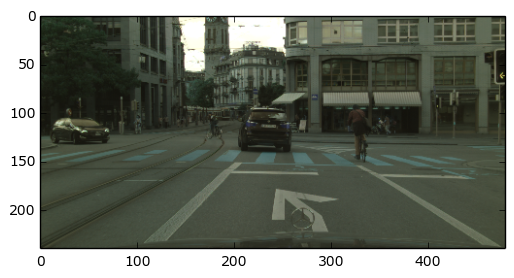

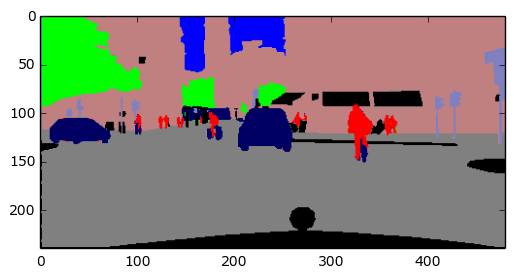

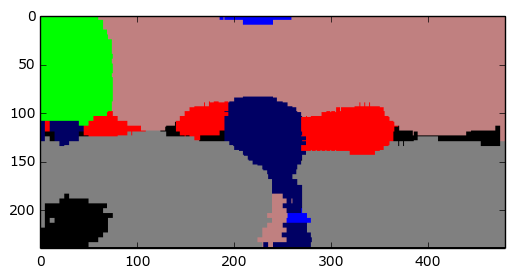

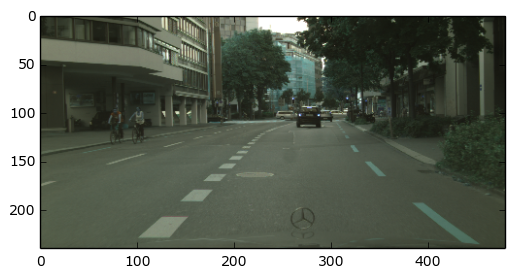

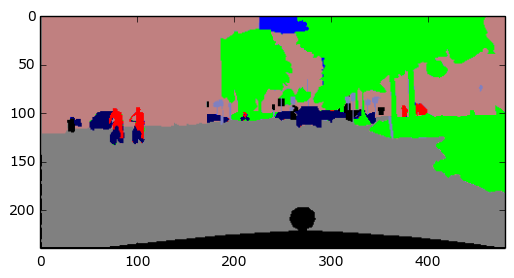

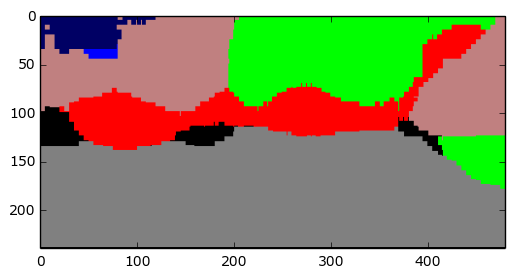

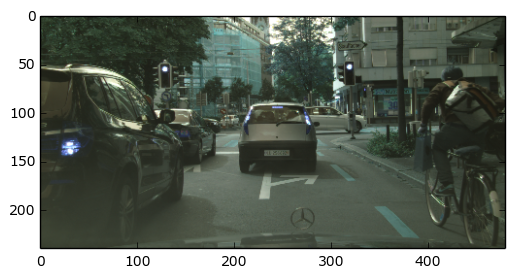

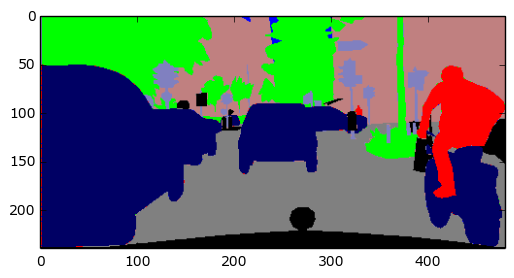

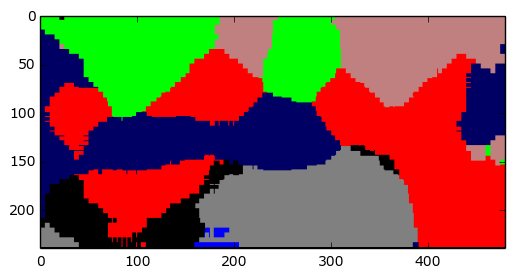

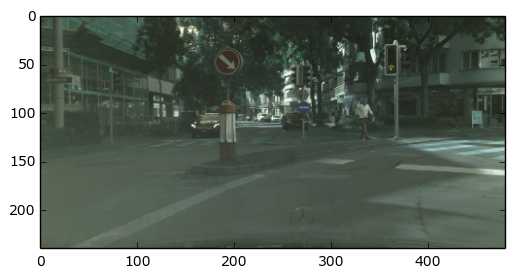

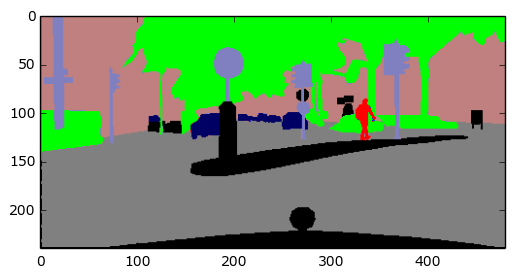

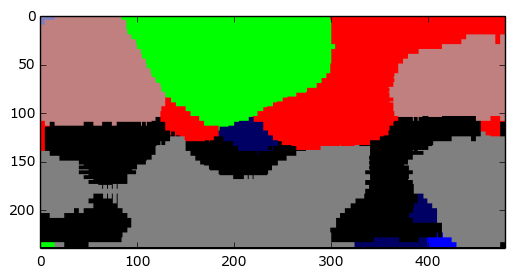

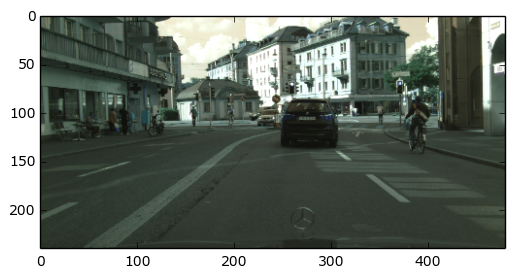

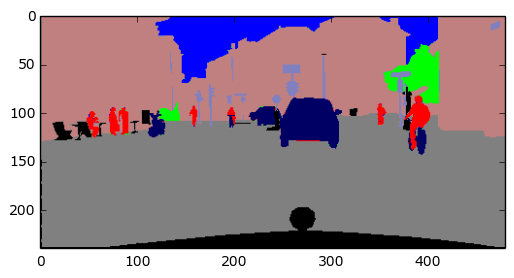

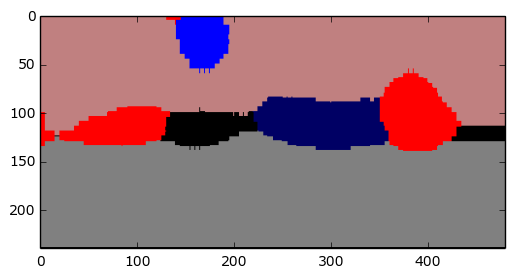

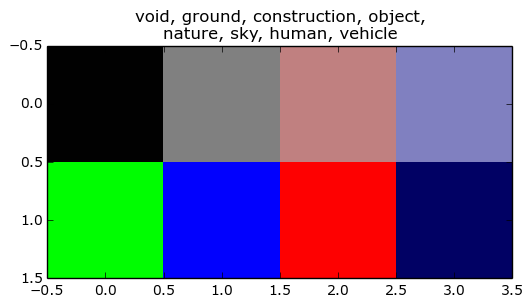

In [26]:
city = 'zurich'

for img_id in range(10,15):
    evaluate(city, img_id,'train')

ref_colors()